In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Change the working directory to your Google Drive
os.chdir('/content/drive/MyDrive/Dataset')

BASE_DIR = 'Images'
WORKING_DIR = '.'

Mounted at /content/drive


In [3]:
input_shape = (224, 224, 3)
base_model = VGG16(weights='imagenet', include_top=True, input_tensor=Input(shape=input_shape))
print("Layers in the original VGG16 model:")
for i, layer in enumerate(base_model.layers):
    # Check if the layer has the 'shape' attribute before printing output_shape
    if hasattr(layer, 'shape'):
        print(f"{i}: {layer.name} - {layer.shape}")
    else:
        print(f"{i}: {layer.name} - {type(layer)}")

# Modify the model to remove the last layer as The second last layer contains rich feature representations
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

print("\nSummary of the modified VGG16 model:")
feature_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Layers in the original VGG16 model:
0: input_layer - <class 'keras.src.layers.core.input_layer.InputLayer'>
1: block1_conv1 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
2: block1_conv2 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
3: block1_pool - <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
4: block2_conv1 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
5: block2_conv2 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
6: block2_pool - <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
7: block3_conv1 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
8: block3_conv2 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
9: block3_conv3 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
10: block3_pool - <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
11: block4_conv1 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
12: block4_conv2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define the path to the image dataset directory


image_folder = os.path.join(BASE_DIR)
print(f"Checking directory: {image_folder}")

print("Path Exists:", os.path.exists(image_folder))

# Ensure the directory exists before proceeding
if not os.path.isdir(image_folder):
    raise FileNotFoundError(f"Error: The directory '{image_folder}' was not found.")

# Retrieve a list of all image filenames in the directory
image_list = os.listdir(image_folder)
image_count = len(image_list)

# Print the number of images detected
print(f"Processing {image_count} images for feature extraction...\n")

# Initialize a dictionary to store the extracted features
image_features = {}

# Iterate through each image in the dataset
for file_name in tqdm(image_list, desc="Extracting Features", unit="img"):

    # Generate the full file path of the image
    file_path = os.path.join(image_folder, file_name)

    try:
        # Load the image and resize it to 224x224 pixels (VGG16 input size)
        img = load_img(file_path, target_size=(224, 224))

        # Convert the image to a NumPy array
        img_array = img_to_array(img)

        # Expand dimensions to match model input format
        img_array = np.expand_dims(img_array, axis=0)

        # Normalize the image according to VGG16 preprocessing requirements
        processed_img = preprocess_input(img_array)

        # Extract features using the pre-trained VGG16 model
        extracted_features = feature_extractor.predict(processed_img, verbose=0)

        # Get image identifier (assuming format 'imageID.jpg' or similar)
        img_id = os.path.splitext(file_name)[0]

        # Store the extracted feature in the dictionary
        image_features[img_id] = extracted_features

    except Exception as error:
        print(f"Skipping {file_name} due to an error: {error}")

# Print a message upon successful completion
print("\nFeature extraction has been successfully completed!")

Checking directory: Images
Path Exists: True
Processing 8101 images for feature extraction...



Extracting Features:   0%|          | 0/8101 [00:00<?, ?img/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)



Feature extraction has been successfully completed!


In [5]:
def open_features(features, directory, filename='features.pkl'):
    file_path = os.path.join(directory, filename)
    with open(file_path, 'wb') as file:
        pickle.dump(features, file)

open_features(image_features, WORKING_DIR)

In [6]:
features_path = os.path.join(WORKING_DIR, 'features.pkl')

# Open the file and load its content into the 'features' variable
with open(features_path, 'rb') as file:
    features = pickle.load(file)

In [7]:
import pickle

# Specify the path to your pickle file
pickle_file = 'features.pkl'

# Load the pickle file
with open(pickle_file, 'rb') as file:
    features_data = pickle.load(file)

# Check the type and content of the data
print(f"Data type: {type(features_data)}")
print(f"Data length: {len(features_data)}")

Data type: <class 'dict'>
Data length: 8101


In [9]:
# Define the file path for the captions text file
captions_file_path = os.path.join(WORKING_DIR, 'captions.txt')

# Open the captions text file in read mode
with open(captions_file_path, 'r') as file:
    # Skip the first line of the file (header or unwanted line)
    next(file)

    # Read the remaining content of the file into 'captions_doc'
    captions_doc = file.read()

In [10]:
# Initialize an empty dictionary to map image IDs to their respective captions
image_to_captions_mapping = {}

# Split the captions document by newline and iterate through each line
captions_lines = captions_doc.split('\n')

# Display the total number of lines to be processed (optional)
print(f"Total number of lines in the captions document: {len(captions_lines)}")

# Start iterating over each line in the captions document
for line_index, line in tqdm(enumerate(captions_lines), total=len(captions_lines), desc="Processing captions"):

    # First, trim any leading or trailing whitespaces from the line
    line = line.strip()

    # Skip any completely empty lines (after trimming)
    if not line:
        continue

    # Split the line by commas (to separate the image ID and its caption(s))
    tokens = line.split(',')

    # Check if the line has at least two parts (image ID and caption)
    if len(tokens) < 2:
        print(f"Skipping line {line_index + 1} due to insufficient data.")
        continue

    # Extract the image ID (first token) and caption (remaining tokens)
    image_id = tokens[0]
    caption_tokens = tokens[1:]

    # Ensure the image ID is clean by removing any file extensions (like .jpg or .png)
    image_id_parts = image_id.split('.')
    image_id_clean = image_id_parts[0]  # We only take the part before the first dot (.)

    # Join the caption tokens into a single string with spaces between words
    caption = " ".join(caption_tokens)

    # If the image ID doesn't exist in the dictionary, create an empty list for it
    if image_id_clean not in image_to_captions_mapping:
        image_to_captions_mapping[image_id_clean] = []

    # Append the caption to the list of captions for this image ID
    image_to_captions_mapping[image_id_clean].append(caption)

    # Optionally print some progress every 1000 lines processed (for large datasets)
    if (line_index + 1) % 1000 == 0:
        print(f"Processed {line_index + 1} lines...")

# At the end, print the size of the dictionary to ensure processing is complete
print(f"Feature extraction complete. Mapped {len(image_to_captions_mapping)} unique images to captions.")

# Optionally, display a sample mapping for verification
sample_image_id = list(image_to_captions_mapping.keys())[0]  # Get a sample image ID
print(f"Sample image ID: {sample_image_id}")
print(f"Sample captions: {image_to_captions_mapping[sample_image_id]}")

Total number of lines in the captions document: 40456


Processing captions:   0%|          | 0/40456 [00:00<?, ?it/s]

Processed 1000 lines...
Processed 2000 lines...
Processed 3000 lines...
Processed 4000 lines...
Processed 5000 lines...
Processed 6000 lines...
Processed 7000 lines...
Processed 8000 lines...
Processed 9000 lines...
Processed 10000 lines...
Processed 11000 lines...
Processed 12000 lines...
Processed 13000 lines...
Processed 14000 lines...
Processed 15000 lines...
Processed 16000 lines...
Processed 17000 lines...
Processed 18000 lines...
Processed 19000 lines...
Processed 20000 lines...
Processed 21000 lines...
Processed 22000 lines...
Processed 23000 lines...
Processed 24000 lines...
Processed 25000 lines...
Processed 26000 lines...
Processed 27000 lines...
Processed 28000 lines...
Processed 29000 lines...
Processed 30000 lines...
Processed 31000 lines...
Processed 32000 lines...
Processed 33000 lines...
Processed 34000 lines...
Processed 35000 lines...
Processed 36000 lines...
Processed 37000 lines...
Processed 38000 lines...
Processed 39000 lines...
Processed 40000 lines...
Feature e

In [11]:
len(image_to_captions_mapping)

8091

In [12]:
def clean(image_to_captions_mapping):
    # Iterate over each key-value pair in the mapping
    for key, captions in image_to_captions_mapping.items():

        # Iterate over each caption in the captions list
        for i in range(len(captions)):

            # Take one caption at a time
            caption = captions[i]

            # Step 1: Convert the entire caption to lowercase
            # Lowercase all characters in the caption so the text is uniform for processing
            caption = caption.lower()

            # Step 2: Remove unwanted characters (digits, punctuation, etc.)
            # We will iterate through each character and keep only alphabetic characters or spaces
            clean_caption = ""
            for char in caption:
                # If the character is a letter or a space, keep it
                if char.isalpha() or char.isspace():
                    clean_caption += char
                # If it's not a letter or space, ignore it

            # After this loop, clean_caption will contain only letters and spaces
            caption = clean_caption

            # Step 3: Remove any extra spaces from the caption
            # This is done by splitting the caption into words (which removes extra spaces)
            # and then joining the words back into a string with a single space between them
            words = caption.split()  # Splits caption into a list of words
            caption = ' '.join(words)  # Joins words back with a single space

            # Step 4: Add start and end tags to the caption
            # We are adding 'startseq' at the beginning and 'endseq' at the end of the caption.
            # Also, we remove any words that are just one character long.
            words = caption.split()  # Split the caption into words again

            # Create a list of words that are longer than 1 character
            filtered_words = []
            for word in words:
                if len(word) > 1:
                    filtered_words.append(word)

            # Join the words back with spaces and add the 'startseq' and 'endseq' tags
            caption = 'startseq ' + ' '.join(filtered_words) + ' endseq'

            # Step 5: Update the list of captions with the modified caption
            captions[i] = caption

In [13]:
image_to_captions_mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
clean(image_to_captions_mapping)

In [15]:
image_to_captions_mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
# Initialize an empty list to store all captions
all_captions = []

# Step 1: Iterate through each key in the image_to_captions_mapping
# Each key in the mapping represents an image, and we want to extract captions for each image.
for key in image_to_captions_mapping:

    # Step 2: Retrieve the list of captions associated with the current key (image)
    captions = image_to_captions_mapping[key]

    # Step 3: Iterate through each caption in the list of captions for the current image
    for caption in captions:

        # Step 4: Append the current caption to the all_captions list
        all_captions.append(caption)

print(f"Total captions collected: {len(all_captions)}")

Total captions collected: 40455


In [17]:
len(all_captions)

40455

In [18]:
all_captions[:15]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

In [19]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_captions)

word_index = tokenizer.word_index

vocab_size = len(word_index) + 1  # Adding 1 to account for the padding token

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8768


In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [21]:
image_ids = list(image_to_captions_mapping.keys())

total_images = len(image_ids)

split_index = int(total_images * 0.90)

train = image_ids[:split_index]

test = image_ids[split_index:]

train_length = len(train)
test_length = len(test)

# Print the number of images in the training and test datasets
print(f"Number of training images: {train_length}")
print(f"Number of testing images: {test_length}")

print("\nData split is completed")

Number of training images: 7281
Number of testing images: 810

Data split is completed


In [22]:
# Define a data generator to load batches of data for model training
def batch_data_generator(image_keys, caption_mapping, image_features_dict, text_tokenizer, max_caption_length, vocabulary_size, batch_size):
    # Initialize empty lists to store images, tokenized input captions, and one-hot encoded output words
    image_data, caption_data, output_data = list(), list(), list()

    # Initialize the sample counter to track the number of processed samples per batch
    sample_count = 0

    # Infinite loop to keep generating data for training
    while 1:
        # Iterate through the list of image keys (IDs)
        for img_key in image_keys:

            # Increment the sample counter for each image processed
            sample_count += 1

            # Retrieve the list of captions associated with the current image ID
            captions = caption_mapping[img_key]

            # Loop through each caption associated with the current image
            for caption in captions:

                # Tokenize the caption into a sequence of integers
                sequence = text_tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs from the tokenized sequence
                for idx in range(1, len(sequence)):

                    # Split the sequence into the input (X) and output (y) parts
                    input_sequence, output_sequence = sequence[:idx], sequence[idx]

                    # Pad the input sequence to a uniform length
                    input_sequence = pad_sequences([input_sequence], maxlen=max_caption_length)[0]

                    # One-hot encode the output sequence (next word in the caption)
                    output_sequence = to_categorical([output_sequence], num_classes=vocabulary_size)[0]

                    if img_key in image_features_dict:
                        # Append the current image feature vector, input sequence, and output sequence to their respective lists
                        image_data.append(image_features_dict[img_key][0])  # Image features
                        caption_data.append(input_sequence)  # Tokenized caption input
                        output_data.append(output_sequence)  # One-hot encoded word output
                    else:
                        # If image key is missing in features, log the missing key
                        print(f"Warning: Missing image features for image ID {img_key}")
                        continue

            # Once we reach the specified batch size, yield the current batch of data
            if sample_count == batch_size:

                # Convert the lists to NumPy arrays for batch processing
                image_data, caption_data, output_data = np.array(image_data), np.array(caption_data), np.array(output_data)

                # Yield the data as a dictionary containing image features and text inputs, and the target output sequence
                yield {"image_input": image_data, "text_input": caption_data}, output_data

                # Reset the lists and counter for the next batch
                image_data, caption_data, output_data = list(), list(), list()
                sample_count = 0

In [23]:
print(f"Available image keys in features: {list(features.keys())}")

Available image keys in features: ['385186343_464f5fc186', '380041023_0dfd712ef1', '409327234_7b29eecb4e', '401079494_562454c4d6', '380590140_25b9889772', '403678611_73978faed7', '407008823_bdd7fc6ed5', '374567836_3ae12ecffb', '380537190_11d6c0a412', '3729405438_6e79077ab2', '3726120436_740bda8416', '404890608_33f138aefa', '374176648_ba4b88c221', '3765374230_cb1bbee0cb', '3726590391_bc6e729bb6', '3730011701_5352e02286', '3737711435_113ccd0a52', '3745451546_fc8ec70cbd', '3741462565_cc35966b7a', '3726168984_1fa2c8965b', '3759492488_592cd78ed1', '391723162_3bdeb7ea33', '390671130_09fdccd52f', '3738789925_7d17dbdf25', '377872472_35805fc143', '3730457171_e66dde8c91', '377872672_d499aae449', '386655611_1329495f97 (1)', '3728256505_7f8db8270d', '374103966_2987706be1', '374103776_0de490c1b0', '405970010_8cebaa77d3', '379006645_b9a2886b51', '396179143_e1511336e1', '380527679_574749123d', '391324644_d23fdf06cb', '405961988_fcfe97f31e', '394161692_2576920777', '385835044_4aa11f6990', '3760400645_

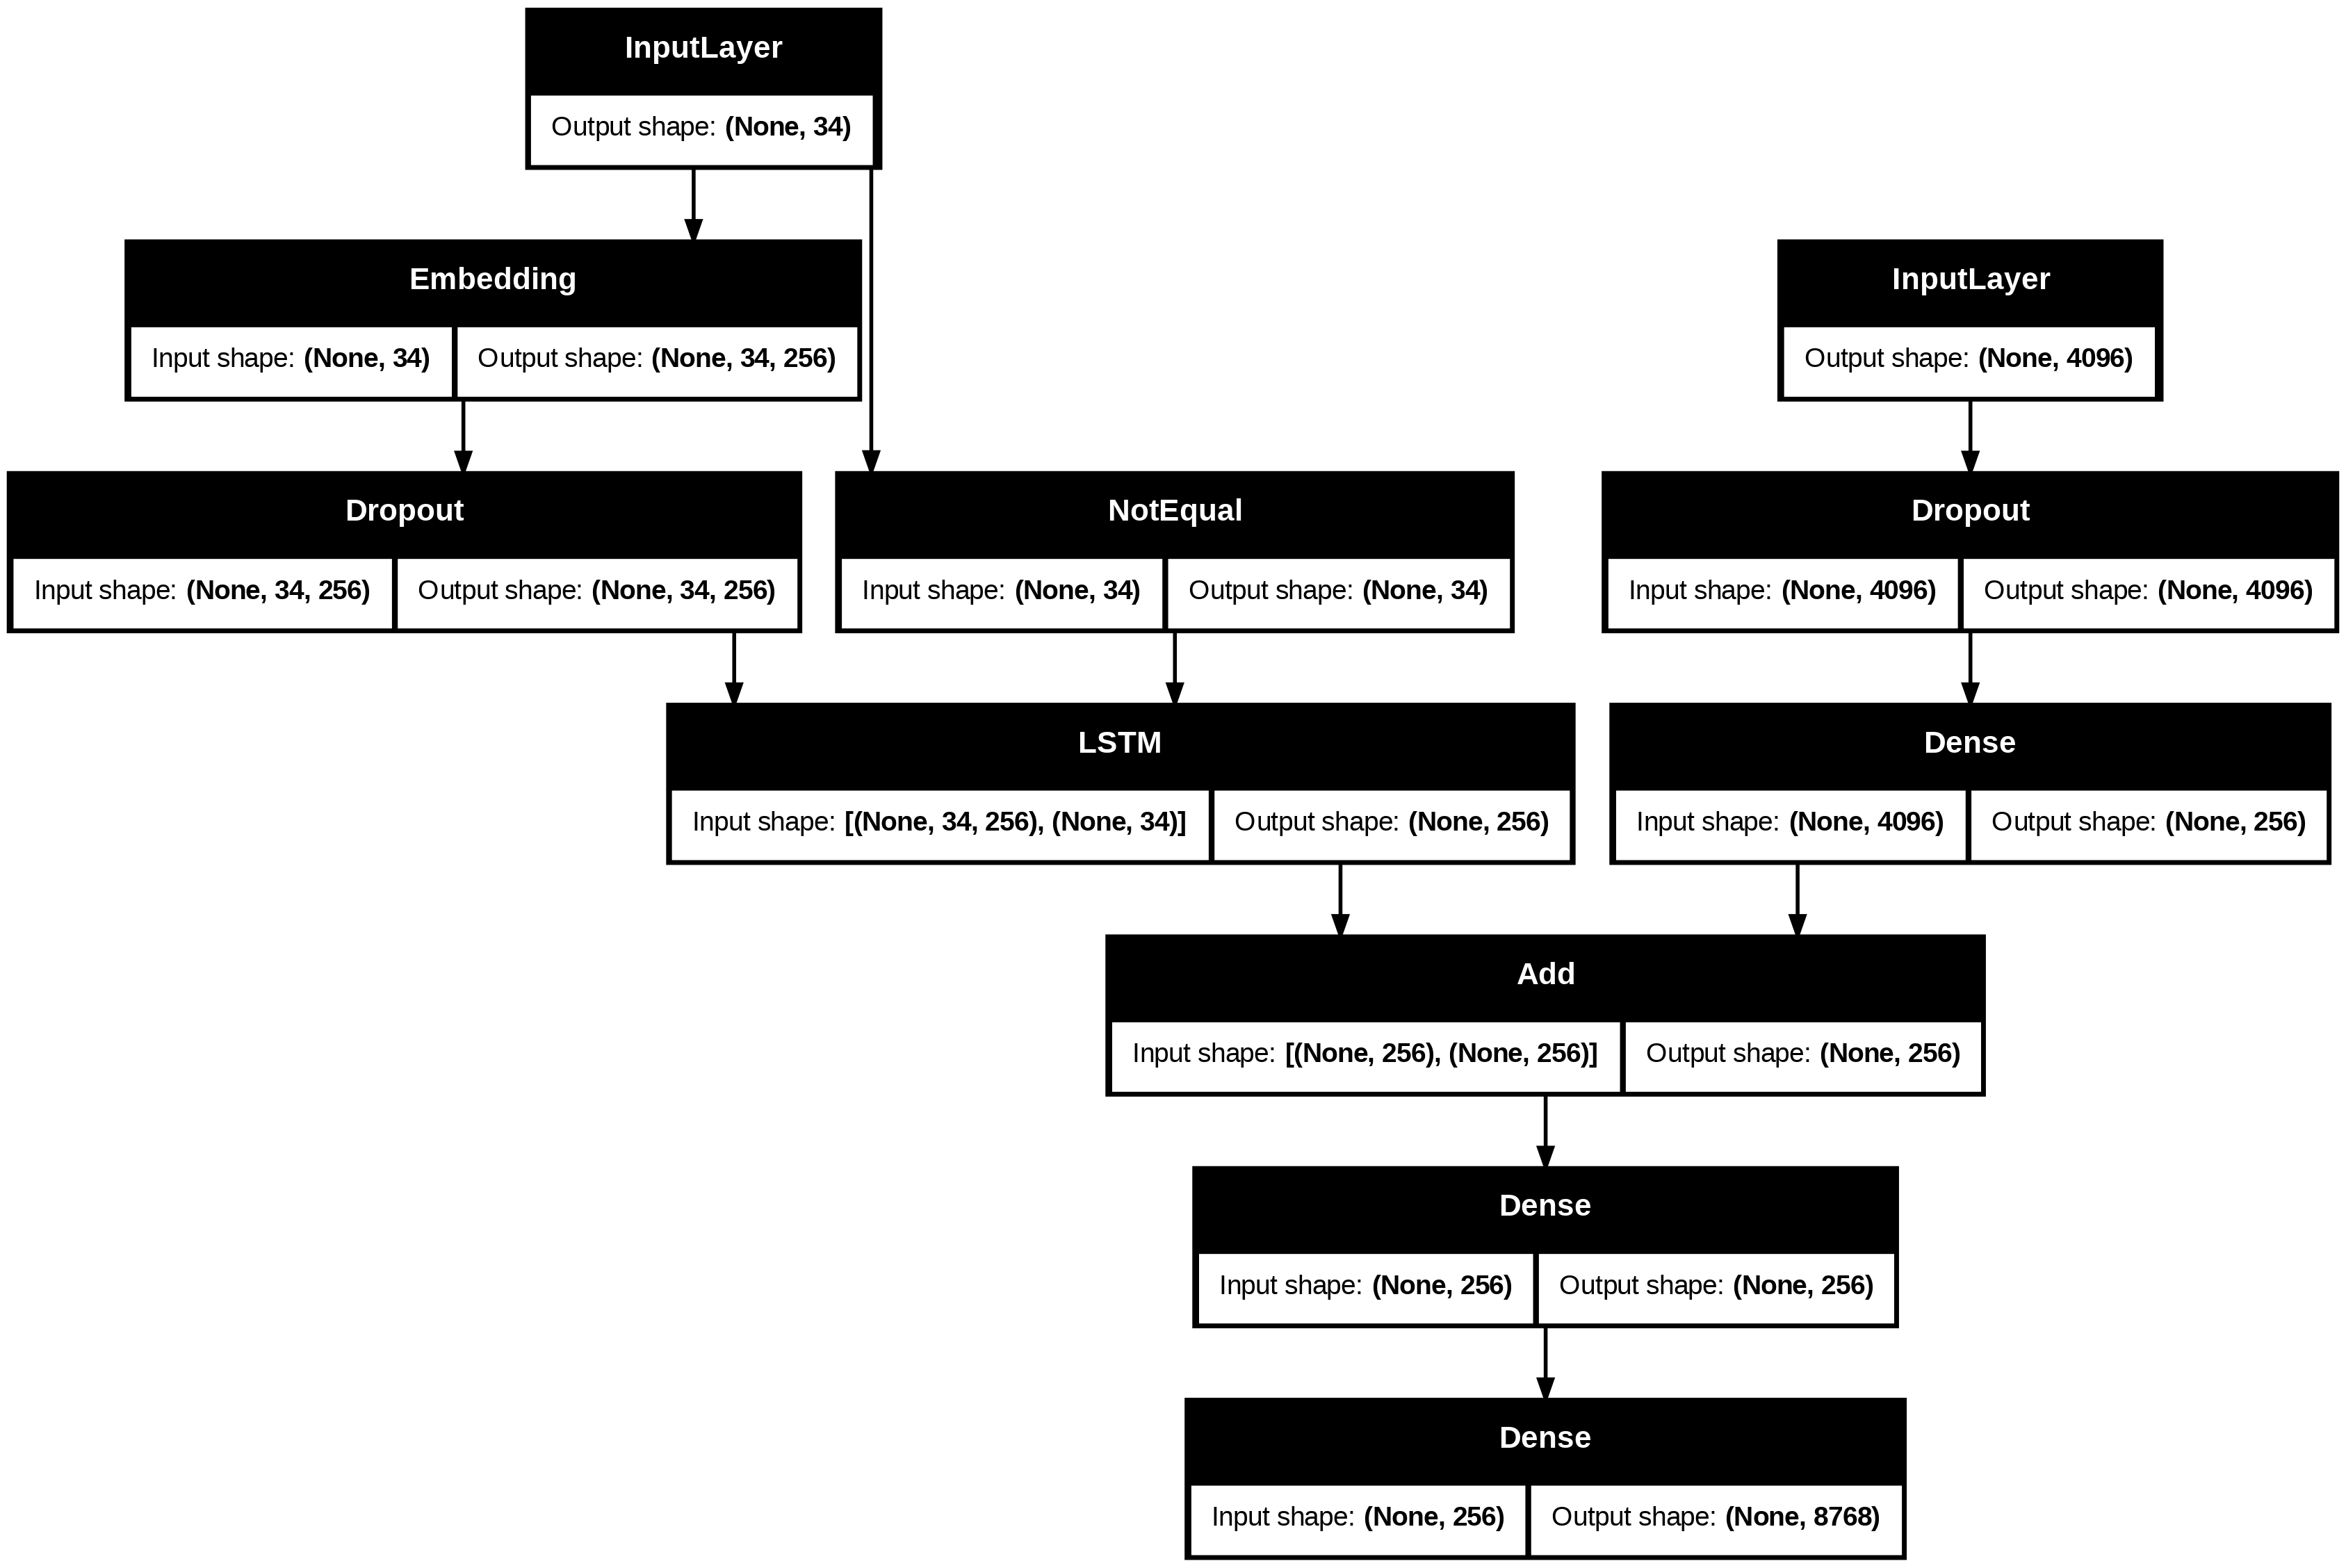

In [27]:
# Define the Encoder Model

# Image Feature Layers
# Input layer for image features (4096-dimensional vector)
image_input = Input(shape=(4096,), name="image_input")

# Apply a dropout layer with a rate of 0.4 to prevent overfitting
image_dropout = Dropout(0.4)(image_input)

# Apply a dense layer with 256 units and ReLU activation for image feature processing
image_dense = Dense(256, activation='relu')(image_dropout)

# Define the Sequence Feature Layers

# Input layer for sequence input (max_length tokens)
text_input = Input(shape=(max_length,), name="text_input")

# Apply an embedding layer that converts word indices to dense vectors (vocab_size, 256)
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)

# Apply a dropout layer with a rate of 0.4 to the sequence features
text_dropout = Dropout(0.4)(text_embedding)

# Apply an LSTM layer with 256 units to process the sequential input
text_lstm = LSTM(256, use_cudnn=False)(text_dropout)

# Define the Decoder Model

# Add the processed image features (image_dense) and sequence features (text_lstm) to merge them
decoder_merge = add([image_dense, text_lstm])

# Apply a dense layer with 256 units and ReLU activation on the merged features
decoder_dense = Dense(256, activation='relu')(decoder_merge)

# Apply a final dense layer with softmax activation to produce probabilities for each word in the vocabulary
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the Complete Model

# Create the model by specifying both the image and text inputs and the final output layer
captioning_model = Model(inputs=[image_input, text_input], outputs=output_layer)

# Compile the model with categorical crossentropy loss function and Adam optimizer
captioning_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model architecture using a plot
# This will output a graphical representation of the model, including input/output shapes
plot_model(captioning_model, show_shapes=True)

# The model is now ready to be trained, where the encoder extracts features from images,
# and the decoder generates a caption for each image based on the sequence input.

In [28]:
print(len(features))

8101


In [29]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):

    # create data generator
    generator = batch_data_generator(train, image_to_captions_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    captioning_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - loss: 5.7859
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 279ms/step - loss: 4.0415
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 289ms/step - loss: 3.5732
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 312ms/step - loss: 3.2928
227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 318ms/step - loss: 3.0848
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 341ms/step - loss: 2.9295
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 322ms/step - loss: 2.8264
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 322ms/step - loss: 2.7364
227/227 ━━━━━━━━━━━━━━━━━━━━ 85s 374ms/step - loss: 2.6601
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 340ms/step - loss: 2.5861


In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'

    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # Get index with high probability
        yhat = np.argmax(yhat)

        # Convert index to word
        word = idx_to_word(yhat, tokenizer)

        # Stop if word not found
        if word is None:
            break

        # Append word as input for generating next word
        in_text += " " + word

        # Stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [32]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = image_to_captions_mapping[key]
    # predict the caption for image
    y_pred = predict_caption(captioning_model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.552172
BLEU-2: 0.322187


In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(WORKING_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(captioning_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles in front of stony wall in city endseq
startseq little boy is standing on the street while man in overalls is working on stone wall endseq
startseq young boy runs aross the street endseq
startseq young child is walking on stone paved street with metal pole and man behind him endseq
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
--------------------Predicted--------------------
startseq man in black jacket and white shirt is walking aross the street endseq


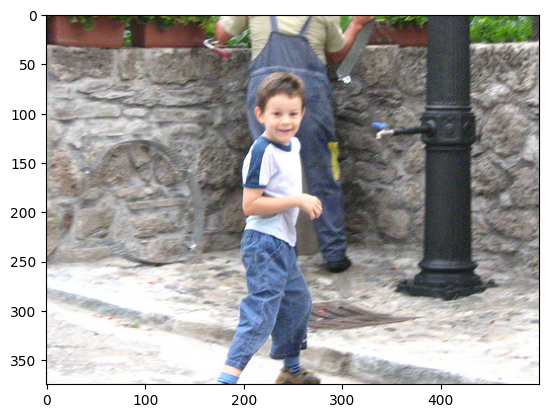

In [45]:
generate_caption("1015118661_980735411b.jpg")

---------------------Actual---------------------
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
--------------------Predicted--------------------
startseq man in kayak kayak endseq


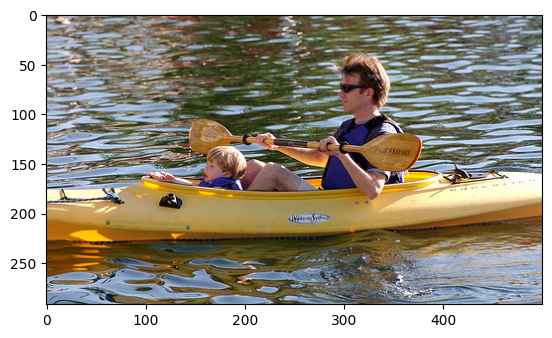

In [47]:
generate_caption("1028205764_7e8df9a2ea.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people in costumes and skiing endseq


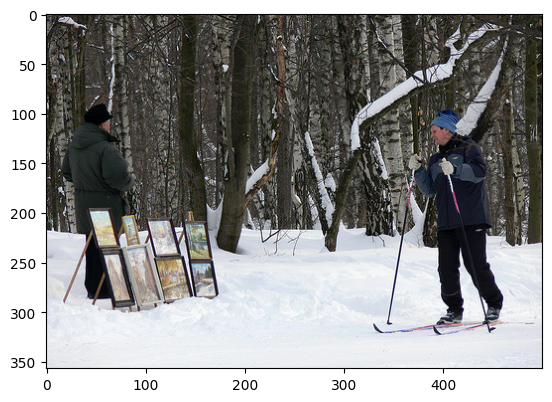

In [56]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq boy jumping in fountain endseq
startseq boy plays in the fountains endseq
startseq child plays in fountain endseq
startseq little boy playing in the water endseq
startseq young boy is jumping through water being sprayed up from the ground endseq
--------------------Predicted--------------------
startseq boy is jumping into water fountain endseq


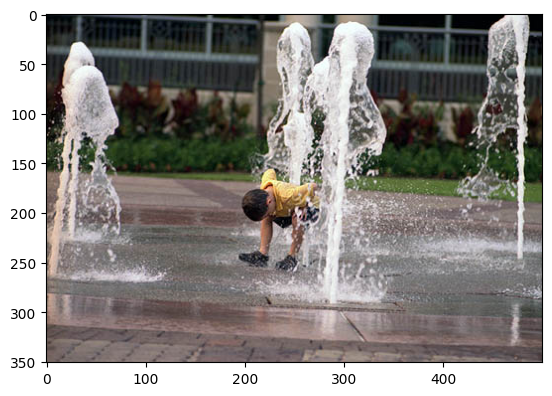

In [55]:
generate_caption("1095476286_87d4f8664e.jpg")

---------------------Actual---------------------
startseq black and white dog catches toy in midair endseq
startseq dog and tennis ball endseq
startseq dog is jumping to catch object thrown at it endseq
startseq dog leaps while chasing tennis ball through grassy field endseq
startseq multicolor dog jumping to catch tennis ball in grassy field endseq
--------------------Predicted--------------------
startseq black and white dog is running in field endseq


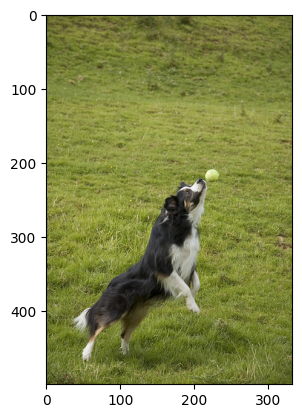

In [53]:
generate_caption("1072153132_53d2bb1b60.jpg")